## Description
In this notebook, we want to study the features affecting sqft_price and check the range and quality of these features.
This serves as pre step for the modeling of house price estimation and its data preprocess.
* use 1-year data to study the correlation of candidate features with sqft_price
* check the feature quality and identify valid range
* find automatic way to clean outliers regarding to sold_price

In [1]:
%load_ext autoreload
%autoreload 1
import os,sys
import numpy as np
import pandas as pd

src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport algorithm
from algorithm import *

import logging
from utils import *
set_logger(logging.WARNING)

### dataset basics

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

pp = Preprocess(df_transaction, df_property)
all_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(all_features ) - set(school_features))
df_all = pp.dataset(feature='all')
df_all_valid = pp.dataset(feature='all', valid=True)
df_1year = pp.dataset(feature='all', date=('2016-10-01', '2017-10-01'))
df_1year['sold_month'] = df_1year['date'].dt.month
df_1year.shape

(1477830, 37)
(710576, 34)


(40520, 40)

In [5]:
df_1year_valid = pp.dataset(feature='all', valid=True, date=('2016-10-01', '2017-10-01'))
df_1year_valid.shape

(34241, 40)

### one year sqft_price histogram

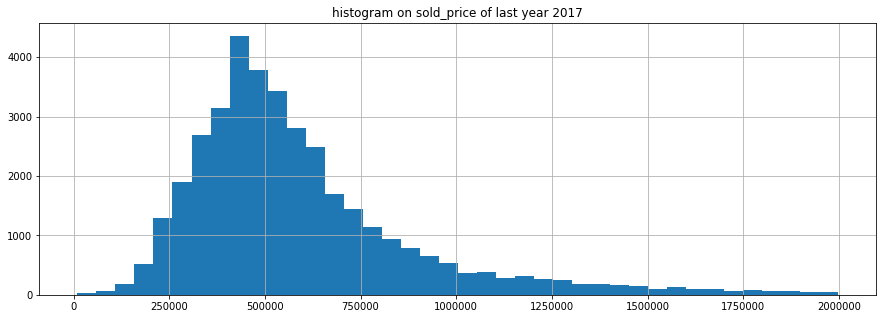

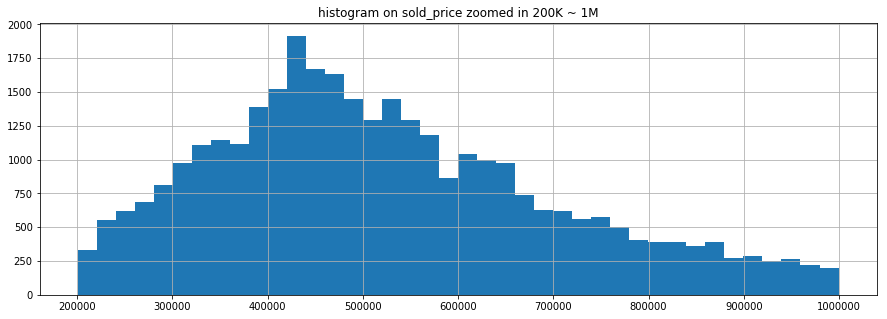

In [3]:
df_1year[(df_1year['sold_price'] > 0) & (df_1year['sold_price'] < 2000000)].hist(column='sold_price', bins=40, figsize=(15, 5))
plt.title('histogram on sold_price of last year 2017')
df_1year[(df_1year['sold_price'] > 200000) & (df_1year['sold_price'] < 1000000)].hist(column='sold_price', bins=40, figsize=(15, 5))
plt.title('histogram on sold_price zoomed in 200K ~ 1M')
plt.show()

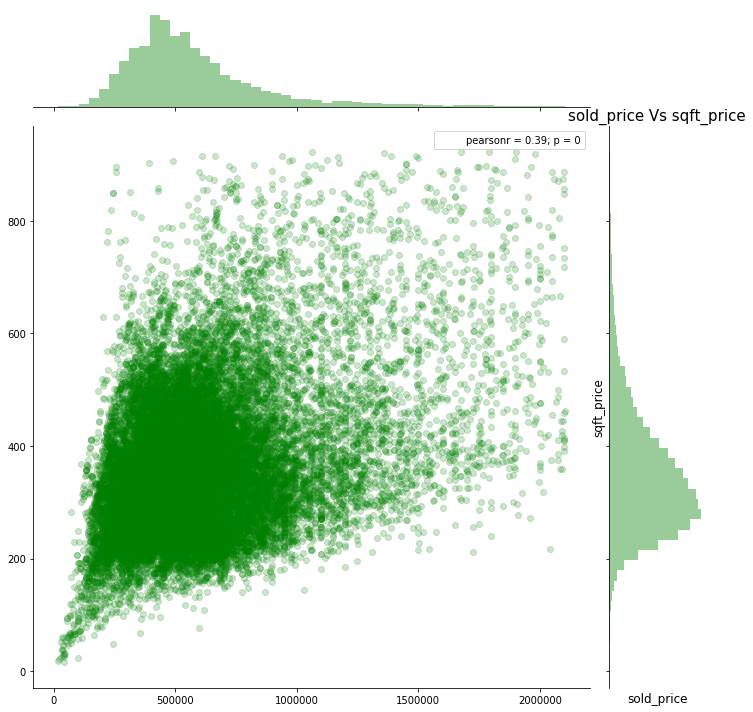

In [40]:
# sold_price or sqft_price: does it matter?
plot_joint_dist(df_1year_valid, 'sold_price', 'sqft_price', 99, 0, 99, 0)

### candidate features for modeling price
* features correlation with sqft_price
* correlation matrix btw features

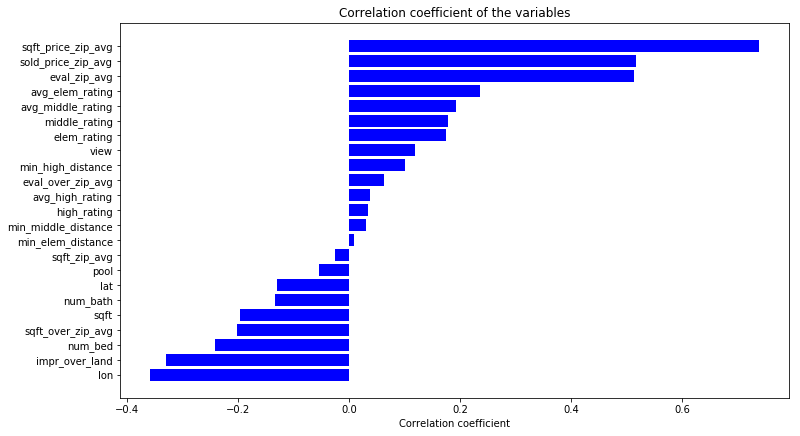

In [41]:
df_corr = plot_correlation(df_1year_valid, 'sqft_price', features)

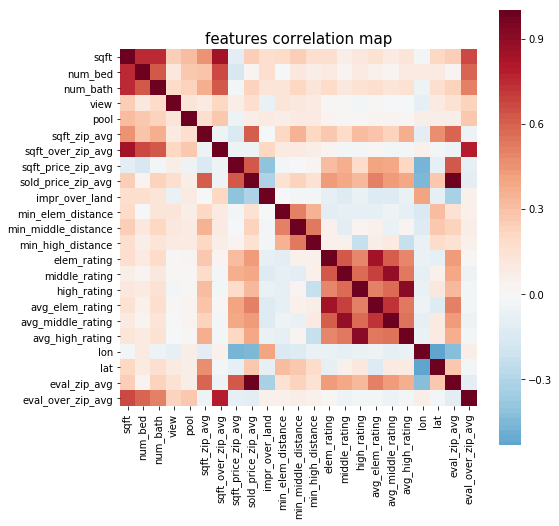

In [42]:
### correlation matrix of delivered features
corrmat = df_1year_valid[features].corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., center=0, square=True, cmap=sns.color_palette("RdBu_r",100))
plt.title("features correlation map", fontsize=15)
plt.show()

### data quality check and cleaning
* missing value
* histogram of features
* cleaning invalid based on general feature criteria
* cleaning outlier automatically by 1.5 IQR range per each zip, since the valid range should be different between zips.

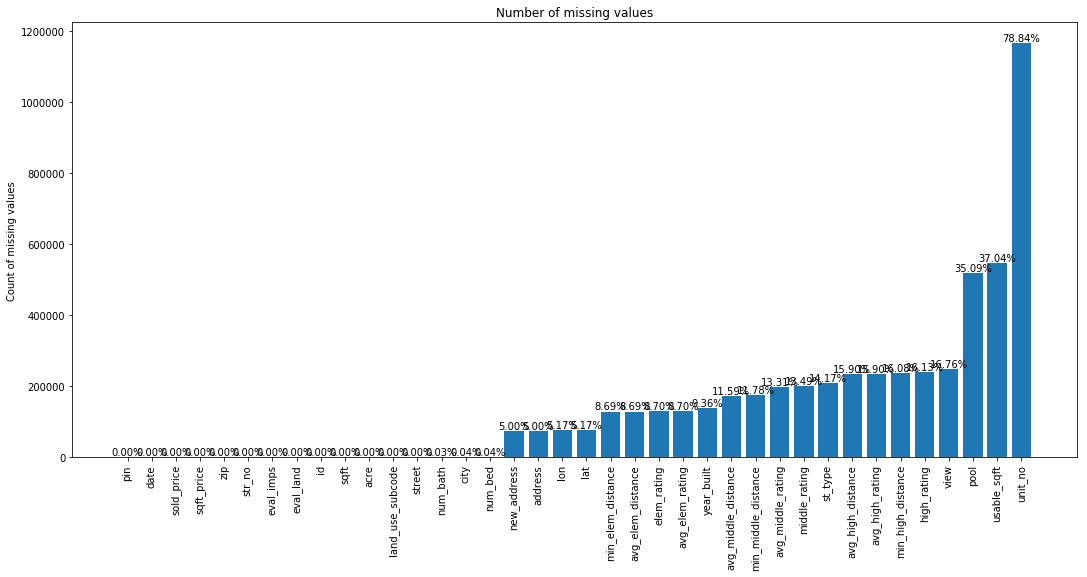

In [32]:
df_missing = df_transaction.isnull().sum(axis=0)
plot_bar(df_missing, ylabel="Count of missing values", title="Number of missing values", total=df_transaction.shape[0], ascending=True)

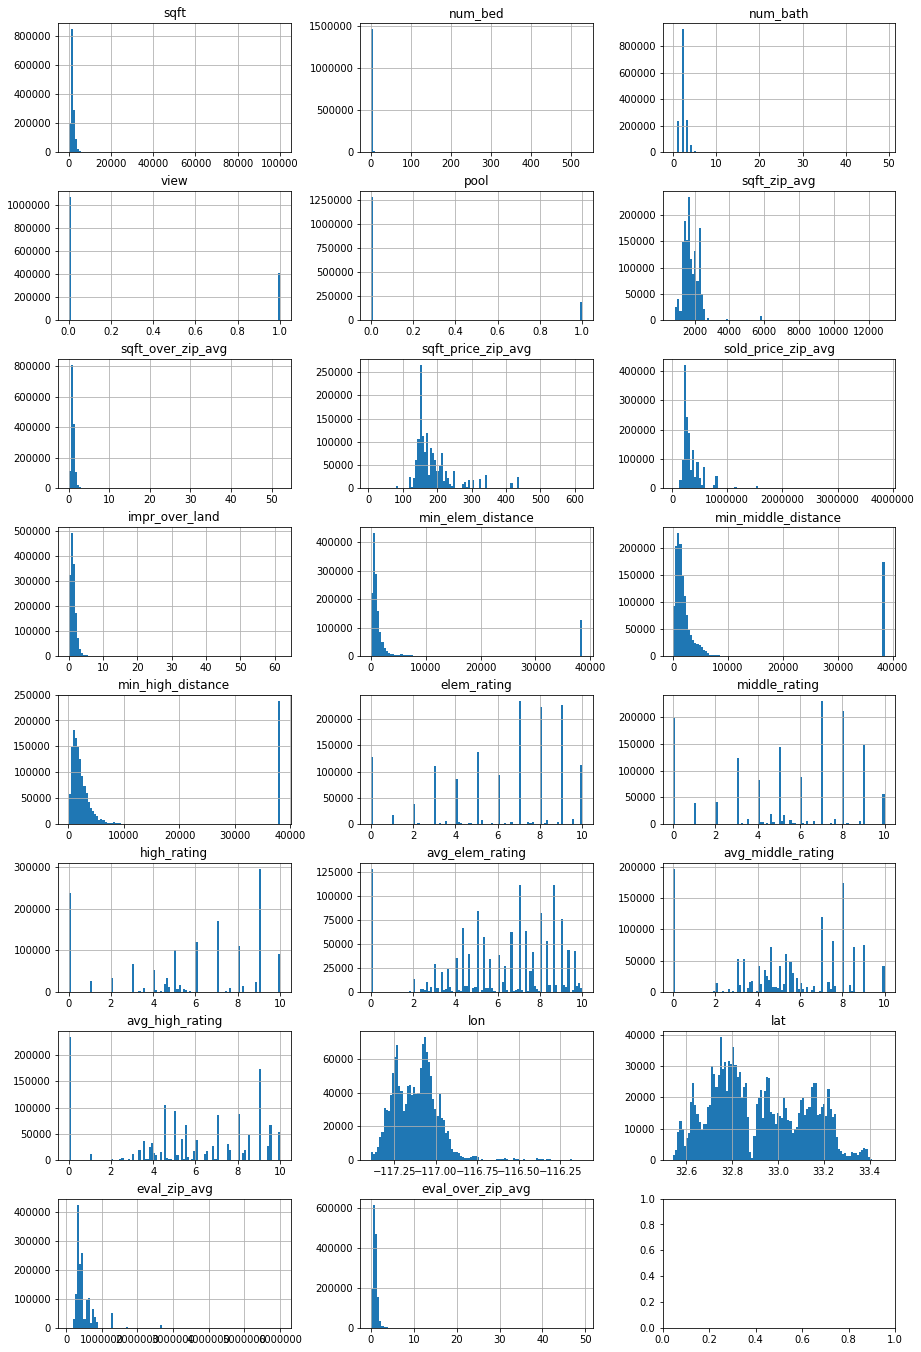

In [33]:
# check various feature distribution
features = [col for col in all_features if df_all[col].dtype in ['float64', 'int64']]
plot_feature_histogram(df_all, list(features))

check after cleaning invalid data


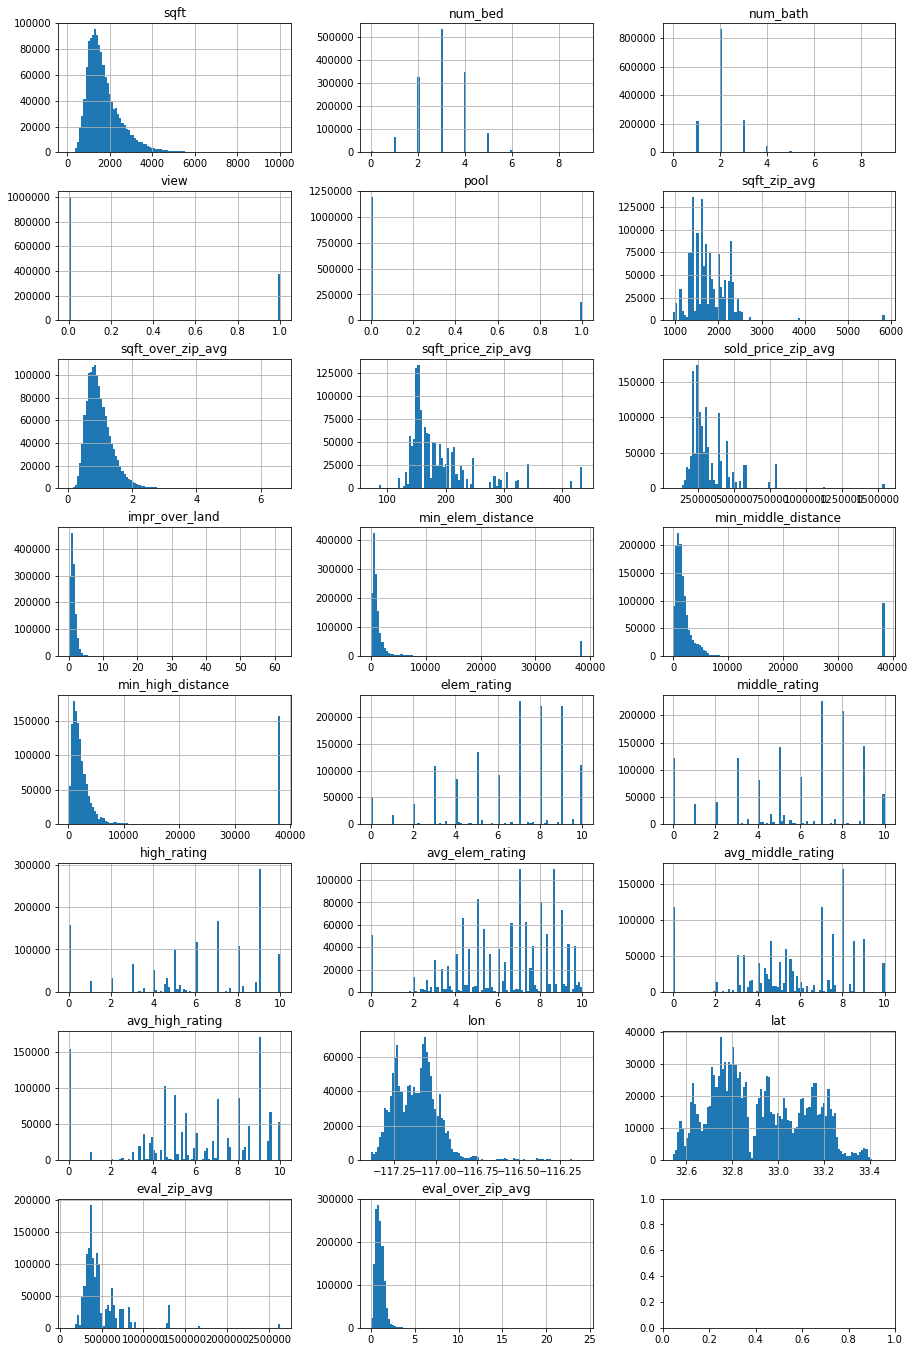

In [36]:
print('check after cleaning invalid data')
plot_feature_histogram(df_all_valid, list(features))

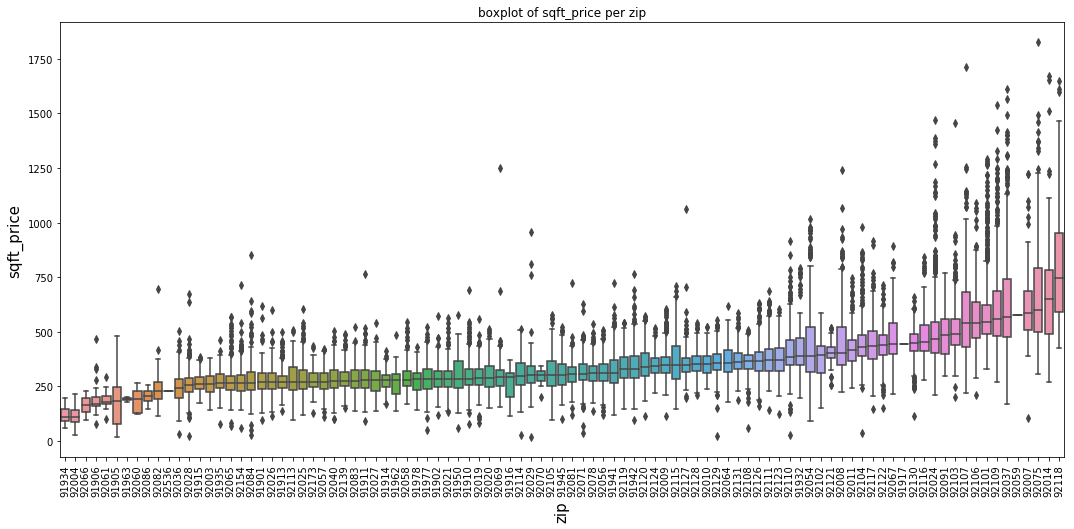

In [38]:
plot_box(df_1year_valid, 'zip', 'sqft_price', order=True)

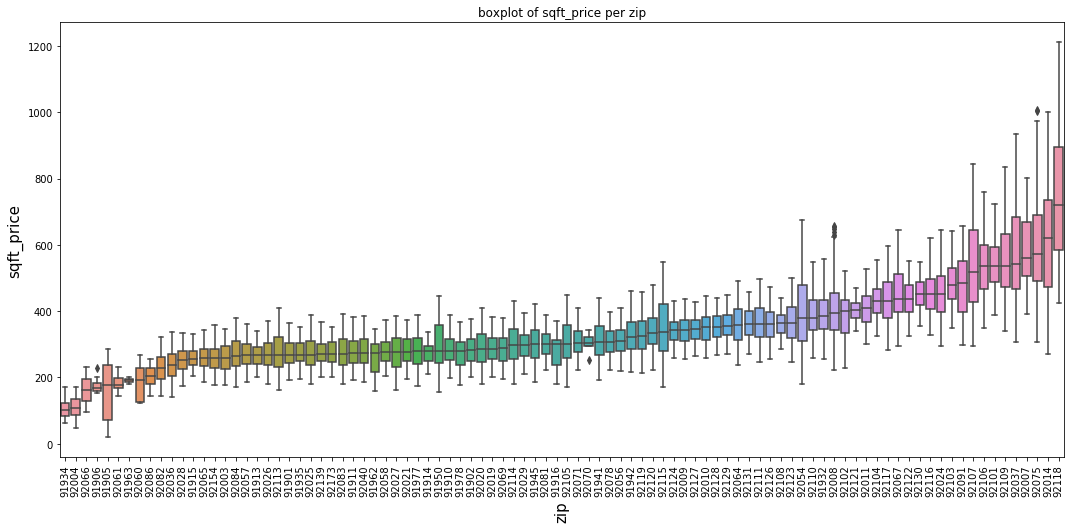

In [39]:
# we can't clean out outliers by simple general range, because the valid range should be different btw zips
# More sensible way is identify the valid range per each zip based on its distribution.
df_1year_valid_clean = pp.dataset(feature='all', valid=True, clean=True, date=('2016-10-01', '2017-10-01'))
plot_box(df_1year_valid_clean, 'zip', 'sqft_price', order=True)